# Clustering de perfiles de OkCupid
Este notebook muestra el proceso de análisis, preprocesamiento y entrenamiento de modelos para agrupar perfiles similares de la web de citas OkCupid.

## 1. Setup

Librerías importadas en el proyecto.

In [ ]:
import numpy as np
import pandas as pd

import os
from collections import namedtuple

from IPython.display import IFrame

try:
    from geopy.geocoders import Nominatim
except ModuleNotFoundError:
    %pip install geopy
    from geopy.geocoders import Nominatim
    
try:
    import geopandas as gpd
    import shapely
except ModuleNotFoundError:
    %pip install fiona
    %pip install geopandas
    %pip install descartes
    import geopandas as gpd
    import shapely

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style("darkgrid")

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

Variables globales declaradas en el proyecto.

In [3]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

#!git clone https://github.com/dietrujillo/ml_lab.git ./ml_lab
# os.path.join(os.curdir, "ml_lab", "lab3", "data")  # Path to csv data
DATA_PATH = os.path.join(os.pardir, "data")
# os.path.join(os.curdir, "ml_lab", "lab3", "info")  # Path to problem info
INFO_PATH = os.path.join(os.pardir, "info")
# os.path.join(os.curdir, "ml_lab", "lab3", "results")  # Path to results files
RESULTS_PATH = os.path.join(os.pardir, "results")

Enunciado del problema.

In [4]:
# Jupyter Notebook only
IFrame(os.path.join(INFO_PATH, "lab3.pdf"), width=1080, height=920)

## 2. Análisis exploratorio de los datos

In [5]:
pd.set_option("display.max_columns", 50)
df = pd.read_csv(os.path.join(DATA_PATH, "okcupid_profiles.csv"))
display(df.iloc[:, :10])
display(df.iloc[:, 10:20])
display(df.iloc[:, 20:31])

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white"
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other"
...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,NaN,NaN,socially,never,graduated from college/university,NaN
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other"
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black"


,height,income,job,last_online,location,offspring,pets,religion,sign,smokes
0,75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes
1,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no
2,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no
3,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no
4,66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no
...,...,...,...,...,...,...,...,...,...,...
59941,62.0,-1,sales / marketing / biz dev,2012-06-12-21-47,"oakland, california",has kids,has dogs,catholicism but not too serious about it,cancer and it&rsquo;s fun to think about,no
59942,72.0,-1,entertainment / media,2012-06-29-11-01,"san francisco, california",doesn't have kids,likes dogs and likes cats,agnosticism,leo but it doesn&rsquo;t matter,no
59943,71.0,100000,construction / craftsmanship,2012-06-27-23-37,"south san francisco, california",doesn't have kids,NaN,christianity but not too serious about it,sagittarius but it doesn&rsquo;t matter,no
59944,73.0,-1,medicine / health,2012-06-23-13-01,"san francisco, california","doesn't have kids, but wants them",likes dogs and likes cats,agnosticism but not too serious about it,leo and it&rsquo;s fun to think about,trying to quit


,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,english,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
59941,english,"vibrant, expressive, caring optimist. i love b...",the happiest times have been when life came to...,i make an outstanding osso bucco. i am also ve...,"i am told that people notice my smile, eyes an...",i am an avid movie watcher and follow the broa...,"my family, my dog, italy, words and music!",writing my book.,"running with my dog, finishing up the work wee...",i have a dream to sing at the alconquin in nyc...,you are seeking a long term connection of shar...
59942,english (fluently),i'm nick. i never know what to write about mys...,currently finishing school for film production...,"filmmaking, photography, graphic design, web d...","dude, i don't know.","movies: hook (the greatest adventure ever!), g...",iphone contact lenses headphones camera tv rem...,i do most of my thinking on the bus to/from wo...,"bringin' home bacon, or drinking and shakin'!",when i was 18 i got a tattoo of waldo somewher...,meh if you made it this far you might as well.
59943,english (fluently),"hello! i enjoy traveling, watching movies, and...","i'm a civil engineer, who enjoys helping the c...",- looking at things objectively - getting thin...,i'm quiet until i get used to the environment ...,"last book: ""game change"". movies: bourne serie...",- iphone - friends and family - internet - bay...,"aside from work, how to improve my home.",out enjoying friendly conversation over dinner.,please let me think about this more.,we have similar interests.
59944,"english (fluently), spanish (poorly), chinese ...","""all i have in this world are my balls and my ...","following my dreams... ""you got a dream... you...",listening,it used to be the hair until i mowed it off bu...,where to begin musically: right now i listen t...,"music, family, friends, a basketball, hoop, so...",what can i do to make someone chuckle....,what i would do on any other day. everydays a ...,i like walking around in other people's house ...,you are interested and interesting...


In [5]:
df.dtypes

age              int64
status          object
sex             object
orientation     object
body_type       object
diet            object
drinks          object
drugs           object
education       object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
pets            object
religion        object
sign            object
smokes          object
speaks          object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
dtype: object

La codificación de los tipos de las variables es correcta, por lo que no será necesario hacer ninguna transformación de tipos.

 Se tienen variables numéricas y textuales. Sin embargo, observando los contenidos de algunas columnas, es evidente que no son de texto libre, y que se pueden considerar variables categóricas. Vamos a definir los diferentes tipos de características:

In [6]:
numerical_vars = ["age", "height", "income"]
categorical_vars = ["status", "sex", "orientation", "body_type", "diet", "drinks", "drugs", "education",
                    "ethnicity", "job", "location", "offspring", "pets", "religion", "sign", "smokes", "speaks"]
text_vars = [f"essay{i}" for i in range(10)]

Llegados a este punto podemos prescindir de una variable que no será de utilidad a la hora de hacer el clustering. Esta variable es `last_online`, que repesenta la fecha y hora de última conexión. Con esta decisión reducimos el volumen de datos y nos centramos en las columnas numéricas y categóricas que aportan información sobre la personalidad, preferencias o apariencia física de una persona.

In [7]:
del df["last_online"]

### 2.1 Análisis de variables numéricas

En primer lugar vamos a echar un vistazo a los estadísticos descriptivos de las variables numéricas  para después abordar un análisis individual de cada una de ellas.

In [8]:
df.describe()

,age,height,income
count,59946.000000,59943.000000,59946.000000
mean,32.340290,68.295281,20033.222534
std,9.452779,3.994803,97346.192104
min,18.000000,1.000000,-1.000000
25%,26.000000,66.000000,-1.000000
50%,30.000000,68.000000,-1.000000
75%,37.000000,71.000000,-1.000000
max,110.000000,95.000000,1000000.000000


En este punto ya podemos observar como hay algunos datos numéricos un tanto extraños:
* La edad máxima es 110, lo cual hace dudar que sea un dato correcto. Posiblemente esta edad corresponda con personas que no quieren compartir su edad verdadera.
* La altura parece estar en pulgadas, *inches*, la media es 68 que se corresponde con 172 cm aprox. En este sentido vemos que la altura mínima es 1 pulgada y que la máxima es de 95 (241 cm). Según la lista de personas más altas del mundo publicada en Wikipedia [1], una altura de entorno a 90 pulgadas (230 cm) ya es algo inaudito. Por otro lado, la altura mínima es 1 pulgada, dato también erróneo.
* Los ingresos llaman la atención en tanto que el ingreso mínimo es -1 y el percentil 75 también es -1. Esto indica que al menos el 75% de los usuarios de la aplicación no han querido decir sus ingresos.

#### 2.2.1 Análisis de la altura

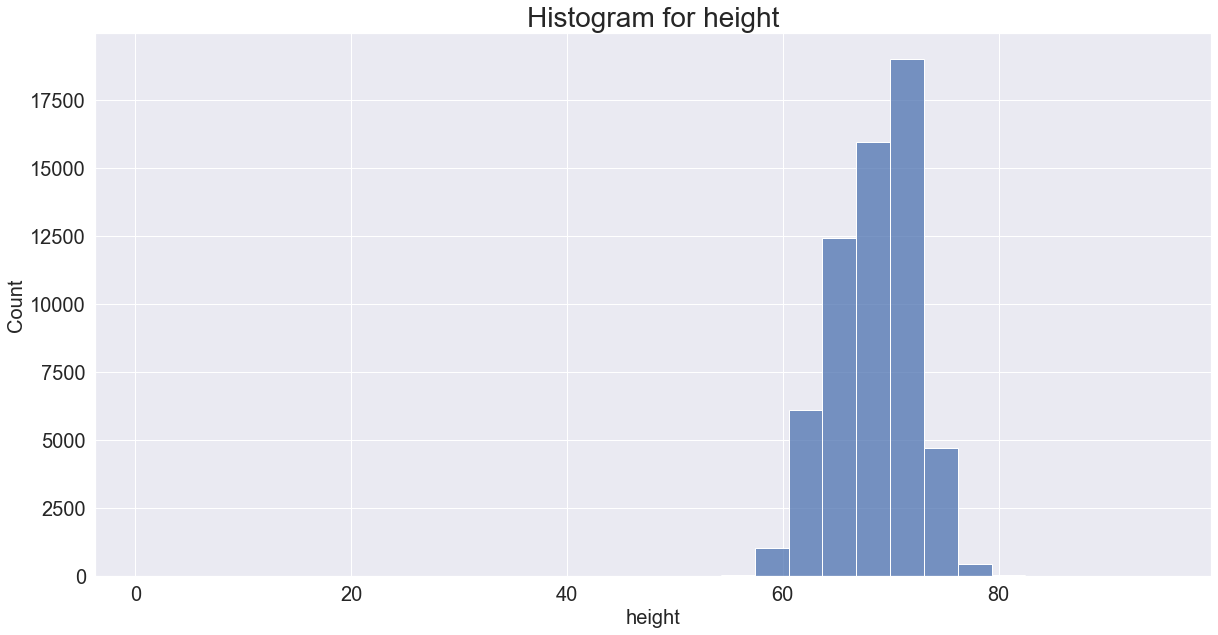

In [9]:
sns.set_theme()
sns.set(rc={'figure.figsize': (20, 10), 'axes.grid': True,
            'axes.labelsize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20})

sns.histplot(data=df["height"], bins=30)

plt.title("Histogram for height", size=28)
plt.show()

Una vez visto el histograma, es de utilidad ver aquellos valores anómalos que no podemos visualizar en el agrupamiento de por clases de un histograma. En la tabla de estadísticos ya vimos algunos indicios de la existencia de valores anómalos, vamos a comprobarlo:

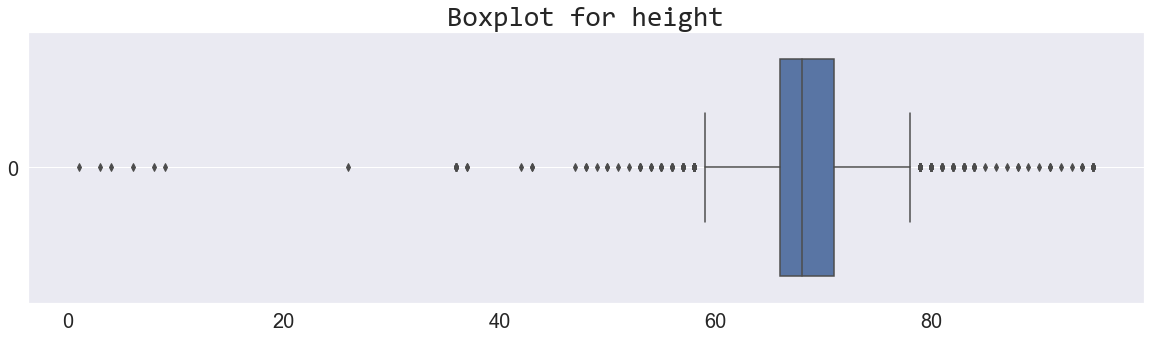

In [10]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=df["height"], orient='horizontal')
plt.title('Boxplot for height', fontdict={"family": "Consolas", "size": 28})
plt.grid()
plt.show()

Como veíamos en la referencia [1], y en la tabla de estadísticos, aquellas personas con altura superior a 80 pulgadas (superior a 203 cm de altura) van a suponer valores anómalos en nuestro conjunto de datos. Podemos ver la frecuencia de estas alturas tan altas e inusuales:

In [11]:
df[df["height"] > 80]["height"].value_counts().sort_index()

81.0    11
82.0    11
83.0    12
84.0     9
85.0     1
86.0     1
87.0     1
88.0     2
89.0     1
90.0     1
91.0     3
92.0     1
93.0     1
94.0     3
95.0    20
Name: height, dtype: int64

Veamos aquellos registros donde la altura es muy pequeña. Aquí podemos establecer un límite inferior coherente de acuerdo con el diagrama de caja y bigotes y partiendo de la base de que podemos contar con usuarios de la apliacación que pueden tener alguna patología como el Enanismo. Según Mayo Clinic [2], una persona que padezca Enanismo podría estar entorno a 122 cm de altura (48 pulgadas), existiendo algunos casos que pueden alcanzar los 91 cm (35.8 pulgadas)

In [12]:
df[df["height"] < 48]["height"].value_counts()

36.0    11
37.0     2
43.0     2
4.0      1
26.0     1
1.0      1
9.0      1
47.0     1
6.0      1
42.0     1
3.0      1
8.0      1
Name: height, dtype: int64

In [13]:
#TODO: ¿ELIMINAMOS?

#### 2.2.2 Análisis de la edad

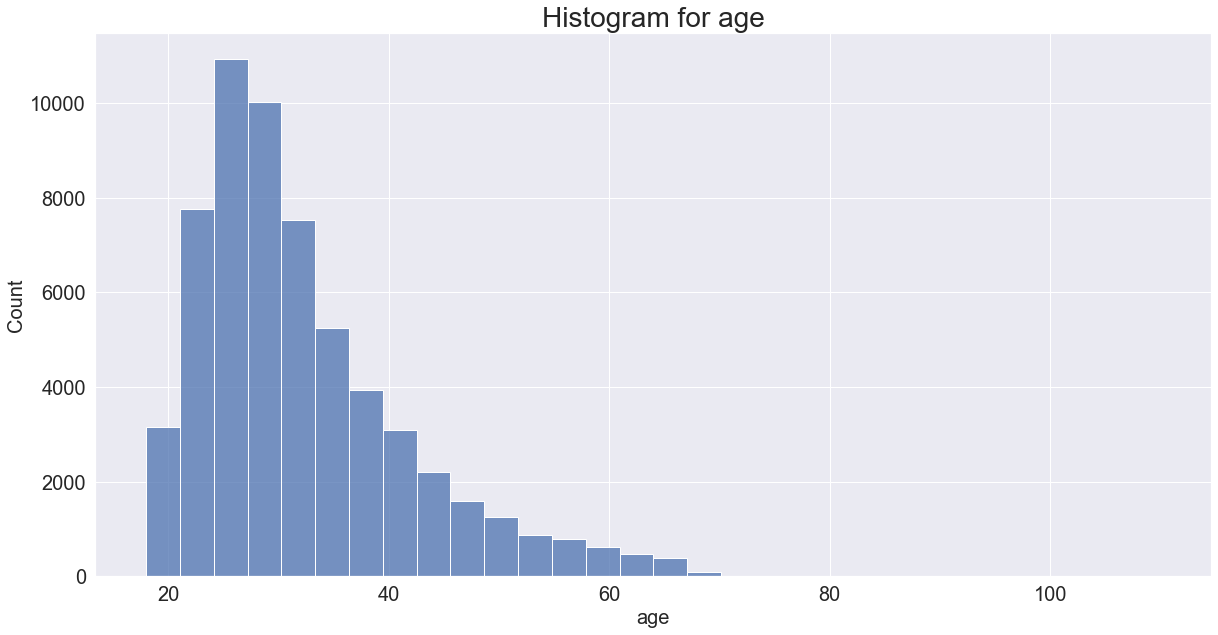

In [14]:
sns.set_theme()
sns.set(rc={'figure.figsize': (20, 10), 'axes.grid': True,
            'axes.labelsize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20})

sns.histplot(data=df["age"], bins=30)

plt.title("Histogram for age", size=28)
plt.show()

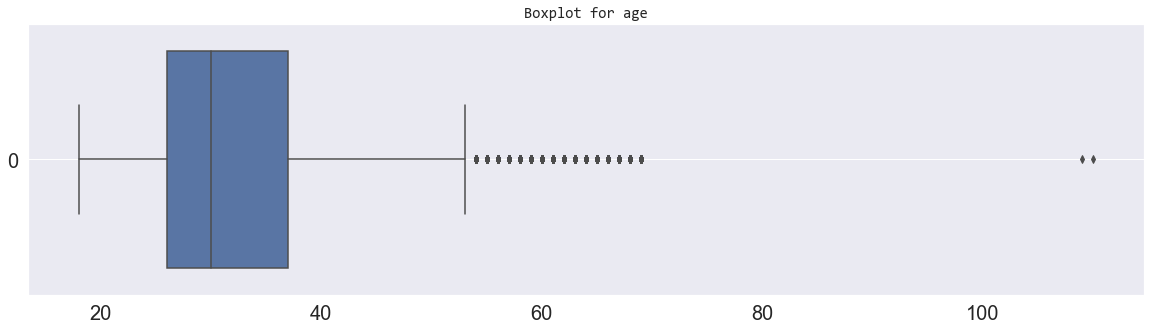

In [15]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=df["age"], orient='horizontal')
plt.title('Boxplot for age', fontdict={"family": "Consolas", "size": 15})
plt.grid()
plt.show()

Vemos como es más inusual que haya usuarios con una edad superior a 55-60 años. Además, como ya vimos, tenemos dos personas con una edad superior a 100 años. Veamos que datos tenemos acerca de ellas:

In [16]:
df[df["age"] > 100]

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
2512,110,single,f,straight,NaN,NaN,NaN,NaN,NaN,NaN,67.0,-1,NaN,"daly city, california",NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25324,109,available,m,straight,athletic,mostly other,NaN,never,working on masters program,NaN,95.0,-1,student,"san francisco, california",might want kids,NaN,other and somewhat serious about it,aquarius but it doesn&rsquo;t matter,when drinking,english (okay),NaN,NaN,NaN,nothing,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.2.3 Análisis de los ingresos

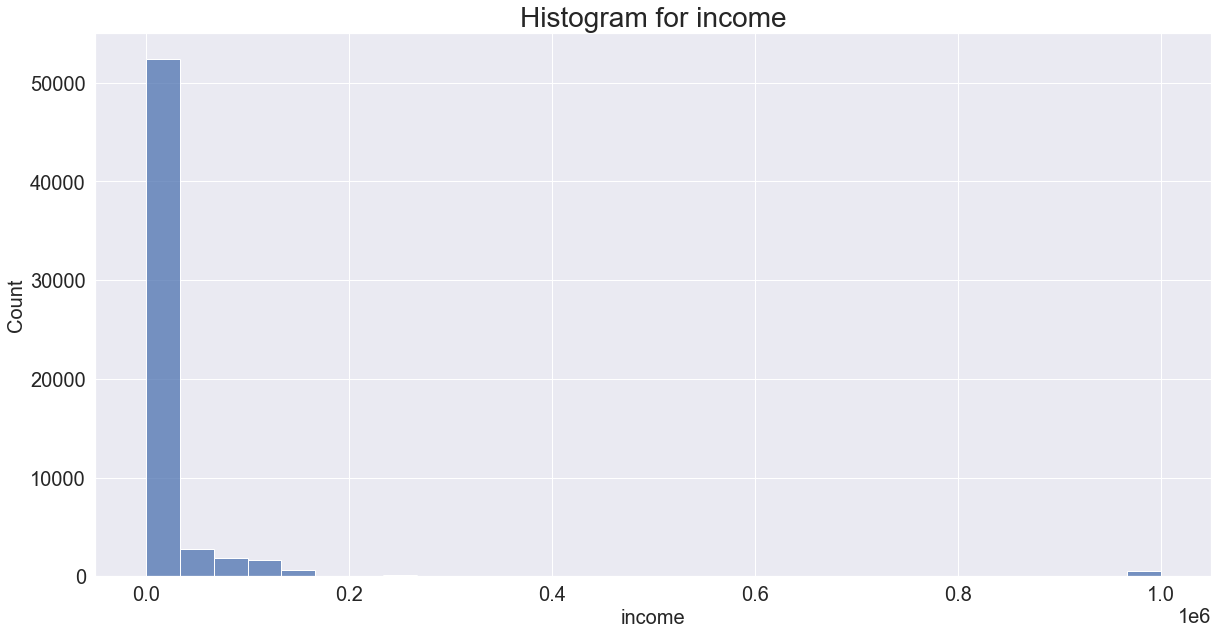

In [17]:
sns.set_theme()
sns.set(rc={'figure.figsize': (20, 10), 'axes.grid': True,
            'axes.labelsize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20})

sns.histplot(data=df["income"], bins=30)

plt.title("Histogram for income", size=28)
plt.show()

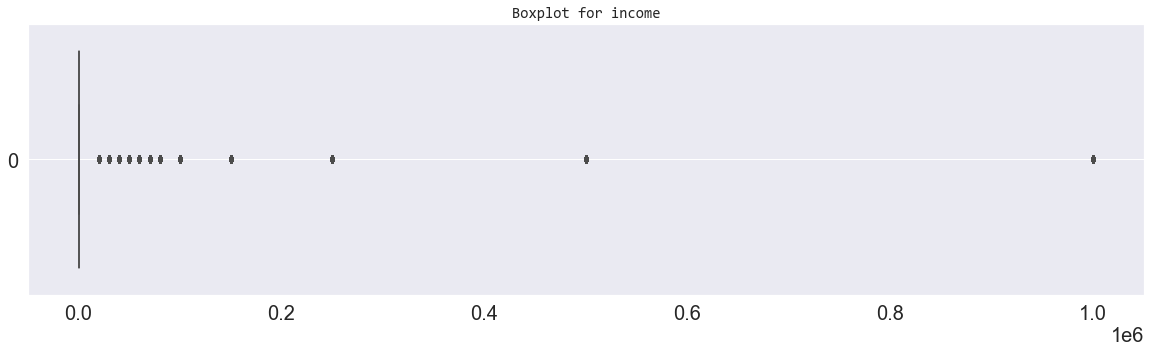

In [18]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=df["income"], orient='horizontal')
plt.title('Boxplot for income', fontdict={"family": "Consolas", "size": 15})
plt.grid()
plt.show()

Como ya habíamos visto en la tabla de los estadísticos, hay un alto porcentaje de personas que han señalado -1 como cantidad de ingresos. Veamos cuál es el porcentaje exacto:

In [19]:
income_percent = (len(df[df["income"] < 0]) / len(df)) * 100
print(f"{round(income_percent)}% with non-specified incomes")

81% with non-specified incomes


Como el promedio obtenido considerando el 100% de los datos no es representativo debido a los datos erróneos, podemos ver la media de aquellos registros en los que sí se ha espeificado alguna cantidad para los ingresos.

In [20]:
avg_income = df[df["income"] > -1]["income"].mean()
avg_income

104394.99304589708

In [21]:
df[df["income"] > -1]["location"].value_counts()

san francisco, california    5092
oakland, california          1551
berkeley, california          742
san mateo, california         318
alameda, california           227
                             ... 
concord, california             1
boulder, colorado               1
cincinnati, ohio                1
new york, new york              1
pacheco, california             1
Name: location, Length: 102, dtype: int64

Si comparamos el promedio obtenido con la media de ingresos de un ciudadano estadounidense (66.778$) [3], nacionalidad con mayor presencia en nuestro conjunto de datos *(véase el apartado 2.2.11 para ampliar información)* vemos que es algo superior. Probablemente los usuarios de esta aplicación han podido inflar la cifra de sus ingresos para tener un *status* más alto del que en realidad pudieran tener.

In [22]:
df[df["income"] > avg_income ]["income"].value_counts().sort_index()

150000     631
250000     149
500000      48
1000000    521
Name: income, dtype: int64

Vemos que hay bastantes registros con ingresos superiores a la media. Los ingresos viene determinados, en general, por la posición laboral en la que se encuentre una persona. Podemos ver a qué se dedican estas personas con salarios tan altos:

In [23]:
df[df["income"] > avg_income]["job"].value_counts()

executive / management               178
computer / hardware / software       164
science / tech / engineering         133
artistic / musical / writer          121
sales / marketing / biz dev          102
other                                 99
banking / financial / real estate     89
medicine / health                     63
student                               58
law / legal services                  52
entertainment / media                 45
education / academia                  41
hospitality / travel                  25
construction / craftsmanship          21
retired                               21
rather not say                        17
political / government                12
transportation                         9
unemployed                             8
military                               5
clerical / administrative              4
Name: job, dtype: int64

Por lo general parece que la mayoría de registros con ingresos altos se corresponden con personas que tienen puestos de ejecutivo, tecnológicos, científicos, artísticos, sanitarios o en la abogacía.

Hay otros que llaman la atención como los jubilados, transportistas y ,sobretodo, desempleados. Los ingresos de estos últimos podrían ser falsos, sin embargo, podríamos deducir que los ingresos no solo vienen determinado por el trabajo, sino también por alquileres, inversiones, ayudas, etc... En definitiva, hay demasiadas variables externas a este contexto y a los datos de los que disponemos como para establecer una línea roja en este sentido que nos derivara a tomar decisiones como la eliminación de registros o la estimación de ingresos.

### 2.2 Análisis de las variables categóricas

#### 2.2.1 Análisis del estado marital

El estado marital debería ser una variable categórica simple. Vamos a ver qué posibles valores hay.

In [24]:
df["status"].value_counts(dropna=False)

single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: status, dtype: int64

Estos posibles estados parecen ser compatibles entre sí. Asumimos que el estado `unknown` significa que el usuario ha preferido no decirlo, no que sea un tipo diferente. Por eso, podremos codificar esta variable como un `one-hot` haciendo que el valor `unknown` sea un vector completo de ceros. Si hubiera valores `nan`, se considerarían igual que `unknown`.

Parece que no hay valores nulos.

#### 2.2.2 Análisis del sexo

In [25]:
df["sex"].value_counts(dropna=False)

m    35829
f    24117
Name: sex, dtype: int64

En este caso parece una variable binaria clara. Parece que hay una predominancia de hombres en la aplicación.

#### 2.2.3 Análisis de la orientación sexual

In [26]:
df["orientation"].value_counts(dropna=False)

straight    51606
gay          5573
bisexual     2767
Name: orientation, dtype: int64

La variable `orientation` tiene tres posibles valores. Sin embargo, en lugar de clasificar como un vector `one-hot`, creemos que a efectos de agrupar perfiles similares, podemos convertir esta variable en dos columnas binarias nuevas, `likes_men` y `likes_women`. Nos basamos en la idea de que el tipo `straight` no significa lo mismo si la persona en cuestión es hombre que si es mujer. Un clustering funcionará mejor si realizamos esta conversión.

#### 2.2.4 Análisis de la complexión corporal

In [27]:
df["body_type"].value_counts(dropna=False)

average           14652
fit               12711
athletic          11819
NaN                5296
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
Name: body_type, dtype: int64

Hay muchos de estos tipos que podemos agrupar desde el principio. Por ejemplo, `fit` y `athletic`. Como perspectiva alternativa, podemos convertirlo en una o varias escalas ordinales. Por ejemplo, una escala de menor a mayor peso, junto con una escala de menor a mayor proporción de grasa a masa muscular. Si seguimos esta segunda alternativa, el tipo `"rather not say"` tendrá que ser considerado `"average"`.

En cualquiera de los casos, los valores nulos se considerarán iguales a `rather not say`.

#### 2.2.5 Análisis de la dieta

In [28]:
df["diet"].value_counts(dropna=False)

NaN                    24395
mostly anything        16585
anything                6183
strictly anything       5113
mostly vegetarian       3444
mostly other            1007
strictly vegetarian      875
vegetarian               667
strictly other           452
mostly vegan             338
other                    331
strictly vegan           228
vegan                    136
mostly kosher             86
mostly halal              48
strictly kosher           18
strictly halal            18
kosher                    11
halal                     11
Name: diet, dtype: int64

Parece que en este caso tenemos tipos de dieta (`anything, vegan, kosher`) con prefijos que muestran lo estricto que son (`mostly, strictly`). Vamos a ver qué tipos hay:

In [29]:
DIET_PREFIXES = set()
DIETS = set()
for item in filter(lambda x: not pd.isnull(x), df["diet"].unique()):
    if " " in item:
        prefix, diet = tuple(item.split())
        DIET_PREFIXES.add(prefix)
        DIETS.add(diet)
    else:
        DIETS.add(item)
print(DIET_PREFIXES)
print(DIETS)

{'strictly', 'mostly'}
{'kosher', 'halal', 'anything', 'vegan', 'vegetarian', 'other'}


\# TODO: how to encode this information (for example: vegetarian and vegan should be close)

#### 2.2.6 Análisis de la bebida

In [30]:
df["drinks"].value_counts(dropna=False)

socially       41780
rarely          5957
often           5164
not at all      3267
NaN             2985
very often       471
desperately      322
Name: drinks, dtype: int64

Esto parece un ejemplo claro de variable ordinal. Hay demasiados valores `NaN` como para eliminarlos, pero podremos utilizar un `imputer` para completar los datos que nos faltan.

#### 2.2.7 Análisis de la toma de drogas

In [31]:
df["drugs"].value_counts(dropna=False)

never        37724
NaN          14080
sometimes     7732
often          410
Name: drugs, dtype: int64

De nuevo, esto parece ser un ejemplo de variable ordinal. Sin embargo, aquí tenemos una hipótesis que comprobaremos más adelante sobre los valores `NaN`: que los valores `NaN` deberían estar en la escala ordinal entre `never` y `sometimes`, porque son personas que han tomado drogas esporádicamente en el pasado, pero que no quieren decir `sometimes`. 

\# TODO: see if we can prove this

#### 2.2.8 Análisis de la educación recibida

In [32]:
df["education"].value_counts(dropna=False)

graduated from college/university    23959
graduated from masters program        8961
NaN                                   6628
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out

Esto parece otro ejemplo de variables con prefijos. Observando las combinaciones únicas que tenemos, podemos extraer los prefijos:

In [33]:
EDU_PREFIXES = ["graduated from", "working on", "dropped out of"]
EDUCATIONS = set()
for item in filter(lambda x: not pd.isnull(x), df["education"].unique()):
    for prefix in EDU_PREFIXES:
        if prefix in item:
            EDUCATIONS.add(item.replace(prefix, "").strip())
print(EDUCATIONS)

{'med school', 'two-year college', 'law school', 'space camp', 'masters program', 'ph.d program', 'high school', 'college/university'}


#### 2.2.9 Análisis de la etnia

In [34]:
df["ethnicity"].value_counts(dropna=False)

white                                                                                        32831
asian                                                                                         6134
NaN                                                                                           5680
hispanic / latin                                                                              2823
black                                                                                         2008
                                                                                             ...  
asian, middle eastern, native american, hispanic / latin, white                                  1
middle eastern, pacific islander                                                                 1
middle eastern, black, native american, indian, pacific islander, hispanic / latin, white        1
middle eastern, native american, white, other                                                    1
middle eas

Este parece un caso en el que tenemos etnias únicas separadas por comas. Podemos extraer los valores únicos separando por las comas.

In [35]:
ETHNICITIES = set()
for item in df["ethnicity"].unique():
    if pd.isnull(item) or not "," in item:
        ETHNICITIES.add(item)
    else:
        for unique_value in item.split(","):
            ETHNICITIES.add(unique_value.strip())
print(ETHNICITIES)

{nan, 'asian', 'native american', 'indian', 'middle eastern', 'pacific islander', 'hispanic / latin', 'black', 'white', 'other'}


En este caso, podemos plantearnos codificar la etnicidad de una persona como un vector que tenga una variable por etnia y un valor que represente el porcentaje que se pertenece a dicha etnicidad, asumiendo igual proporción de las etnicidades que el usuario suministre al sistema. Por ejemplo, una persona de ascendencia asiática tendrá un 1 en la columna de etnicidad asiática y 0 en el resto (como al hacer un one-hot encoding), mientras que alguien biracial de etnias caucásica y africana tendrá 0.5 en estas dos categorías y 0 en el resto. Vamos a mirar cuál es el número de etnicidades que la gente aporta al sistema en general:

In [36]:
ethnicity_counts = df["ethnicity"].apply(lambda x: x.count(",") + 1 if not pd.isnull(x) else 0)
print(f"Media: {ethnicity_counts.mean()}")
print(f"Q1: {ethnicity_counts.quantile(0.25)}")
print(f"Mediana: {ethnicity_counts.median()}")
print(f"Q3: {ethnicity_counts.quantile(0.75)}")
print(f"P95: {ethnicity_counts.quantile(0.95)}")
print(f"Moda: {ethnicity_counts.mode().iloc[0]}")
print(f"Máximo: {ethnicity_counts.max()}")

Media: 1.0588863310312615
Q1: 1.0
Mediana: 1.0
Q3: 1.0
P95: 2.0
Moda: 1
Máximo: 9


La mayoría de usuarios han dado una sola etnicidad. Sin embargo, algunos han llegado a dar 9. Esto nos dará problemas, porque si seguimos nuestra codificación habrá vectores en los que el valor será $\frac{1}{9}$, un valor minúsculo. Si asumimos que las etnicidades se han proporcionado al programa en orden de prioridad, podemos quedarnos con las tres o cuatro más relevantes cogiendo las tres o cuatro primeras. Vamos a ver si es posible que se hayan proporcionado en orden de prioridad.

In [37]:
all(df["ethnicity"].apply(lambda x: x.split() == sorted(x.split()) if not pd.isnull(x) else True))

False

De aquí sacamos que el orden no es alfabético, lo cual nos indica que lo más probable es que estén ordenados por prioridad. No podemos estar seguros, pero todo indica a que este es el caso. Por eso, utilizaremos sólo las tres primeras etnicidades que el usuario proporcione.

#### 2.2.10 Análisis de la ocupación laboral

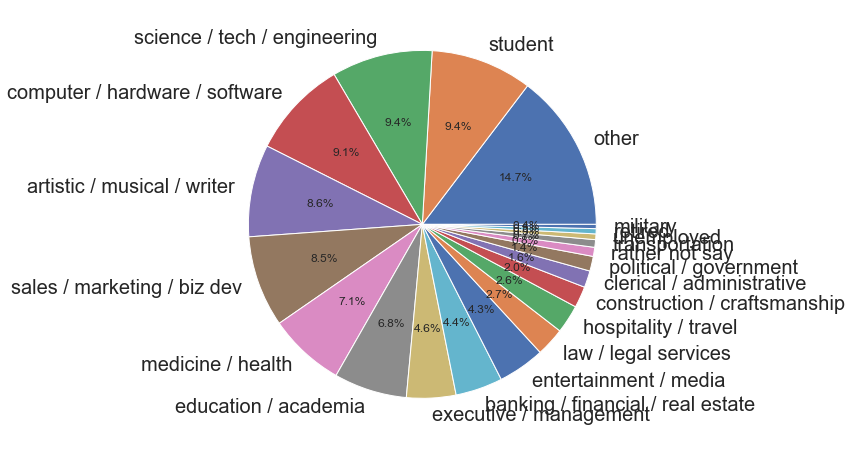

In [38]:
plt.figure(figsize=(20, 8))
plt.pie(df["job"].value_counts(), labels=df["job"].value_counts().keys(), autopct="%1.1f%%")
plt.show()

Parece que este es un caso claro de variable categórica sin más. Quizás fuera beneficioso mezclar algunos campos, como los de `science` con `academia` o `computer/hardware/software` con `tech`. Sin embargo, como los campos ya vienen mezclados, no se puede hacer una conversión así. En este caso no daremos un tratamiento especial a `other`, sino que lo consideraremos un tipo más en el one-hot.

\# TODO: justify why one-hot to other

#### 2.2.11 Análisis de la localización geográfica

In [39]:
df["location"].value_counts(dropna=False)

san francisco, california    31064
oakland, california           7214
berkeley, california          4212
san mateo, california         1331
palo alto, california         1064
                             ...  
milwaukee, wisconsin             1
canyon, california               1
crowley, texas                   1
marin city, california           1
rochester, michigan              1
Name: location, Length: 199, dtype: int64

Lo primero es ver si hay valores nulos.

In [40]:
any(df["location"].isnull())

False

Parece que todas las localizaciones siguen la forma [ciudad], [estado]. Debemos comprobar si es el caso para todos.

In [41]:
all(df["location"].apply(lambda x: x.count(",") == 1))

False

In [42]:
df["location"][df["location"].apply(lambda x: x.count(",") != 1)]

42438    vancouver, british columbia, canada
Name: location, dtype: object

Sólo el caso de una sóla fila de un usuario de Vancouver tiene tres partes. Esto es porque Canadá tiene estados. En general, el formato [ciudad], [estado] parece cumplirse siempre, siendo [ciudad], [país] si no hablamos de Estados Unidos.

In [43]:
vancouver = df["location"][df["location"].apply(lambda x: x.count(",") != 1)]
assert len(vancouver) == 1
vancouver_id = vancouver.index[0]

df.at[vancouver_id, "location"] = "vancouver, canada"

In [44]:
all(df["location"].apply(lambda x: x.count(",") == 1))

True

Ahora que parece que todo está en el mismo formato, vamos a codificar la localización en latitud y longitud. Para ello utilizaremos la clase [`Nominatim`](https://geopy.readthedocs.io/en/stable/#nominatim) de `geopy`.

In [45]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')

Coordinates = namedtuple("Coordinates", ("latitude", "longitude"))

def get_coordinates(loc):
    city, state = loc.title().split(",")
    geocode = geolocator.geocode(f"{city} {state}")
    return Coordinates(geocode.latitude, geocode.longitude)
    
COORDINATES_DICT = {}
for location in df["location"].unique():
    COORDINATES_DICT[location] = get_coordinates(location)
    
for location in df["location"].unique()[:5]:
    print(location, COORDINATES_DICT[location].latitude, COORDINATES_DICT[location].longitude)

south san francisco, california 37.6535403 -122.4168664
oakland, california 37.8044557 -122.2713563
san francisco, california 37.7790262 -122.4199061
berkeley, california 37.8708393 -122.2728639
belvedere tiburon, california 37.8771208 -122.4616696


Para asegurarnos de que no hay errores, en lugar de ir comprobando los datos uno a uno podemos simplemente mostrar una imagen con las localizaciones en un mapa. Utilizamos una escala logarítmica para visualizar bien las diferencias entre puntos.

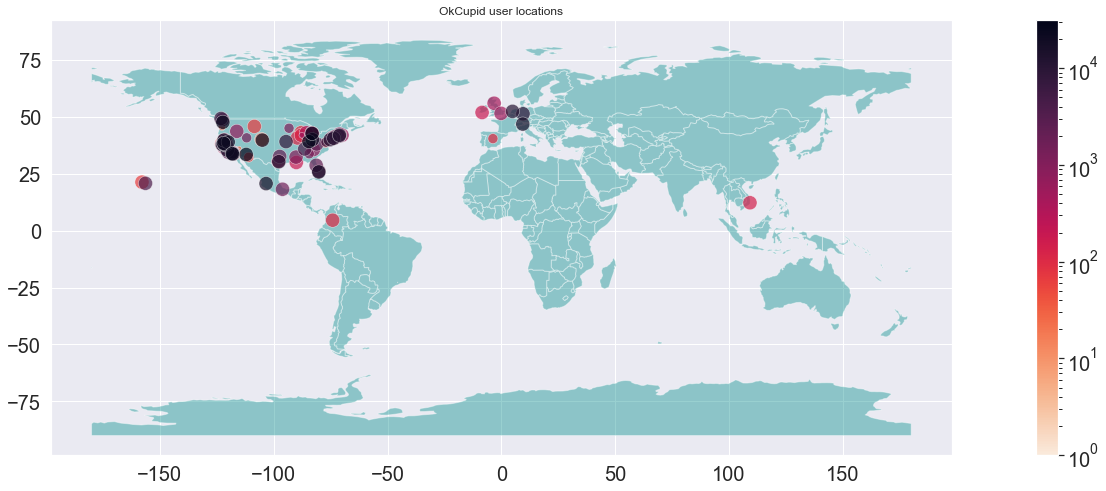

In [46]:
geometry = [shapely.geometry.Point(lon, lat) for lat, lon in COORDINATES_DICT.values()]
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

locations = gpd.GeoDataFrame({"location": COORDINATES_DICT.keys()}, geometry=geometry)
counts = df["location"].value_counts()
locations["count"] = [counts.loc[x] for x in COORDINATES_DICT.keys()]

fig, ax = plt.subplots(figsize=(30, 8))
ax.set_title("OkCupid user locations". fontdict={"size": 24, "family": "Consolas"})
world.plot(ax=ax, color="darkcyan", alpha=0.4)
scale = locations["count"]
locations.plot(ax=ax, alpha=0.7, edgecolor="white", linewidth=0.5, markersize=200/scale, c=scale, cmap="rocket_r")
mappable = ScalarMappable(cmap="rocket_r", norm=LogNorm())
mappable.set_array(scale.to_numpy())
plt.colorbar(mappable=mappable, ax=ax)
plt.show()

Ahora tenemos las coordenadas de cada persona y sabemos que la codificación es correcta. Vamos a preparar un transformador que convertirá una localización en un array de coordenadas.

In [158]:
def string_to_tuple_transformer(transformer_dict):
    
    def _transformer(X, transformer_dict_inner):
        assert len(X.shape) == 2
        X = X[:, 0]
        
        output_shape = len(list(transformer_dict_inner.values())[0])
        assert all([len(x) == output_shape for x in transformer_dict_inner.values()])
        
        ret = np.zeros((len(X), output_shape), dtype=float)
        for i in range(len(X)):
            row = []
            for j in range(output_shape):
                row.append(transformer_dict_inner[X[i]][j])
            ret[i] = np.array(row)
            
        return ret
    
    return FunctionTransformer(lambda param: _transformer(param, transformer_dict))

In [160]:
string_to_tuple_transformer(PET_STATUS_DICT)

array([[1., 0.],
       [1., 1.]])

#### 2.2.12 Análisis de los hijos

In [47]:
df["offspring"].value_counts(dropna=False)

NaN                                        35561
doesn't have kids                           7560
doesn't have kids, but might want them      3875
doesn't have kids, but wants them           3565
doesn't want kids                           2927
has kids                                    1883
has a kid                                   1881
doesn't have kids, and doesn't want any     1132
has kids, but doesn't want more              442
has a kid, but doesn't want more             275
has a kid, and might want more               231
wants kids                                   225
might want kids                              182
has kids, and might want more                115
has a kid, and wants more                     71
has kids, and wants more                      21
Name: offspring, dtype: int64

En este caso, podemos definir esta variable en dos columnas, `has_kids` y `wants_kids`. Podemos definir 0 si no quiere o tiene hijos, 1 si tiene o quiere hijos y 0.5 si no lo sabe, no lo tiene claro o no ha contestado. Esto nos va a permitir unificar bastante bien todos los tipos que aparecen, ya que en muchos de ellos hay colisiones.

Para evitar hacer procesamiento del lenguaje natural, que es completamente innecesario en este caso, podemos simplemente indicar el valor de `wants_kids` y `has_kids` para cada posible entrada de `offspring`. Haremos las siguientes asunciones:

- Si el usuario indica que quiere hijos o que podría quererlos en el futuro sin indicar nada más, asumimos que no tiene.
- Si el usuario indica que no quiere hijos sin indicar si los tiene, asumimos que no los tiene.
- Los casos de tener un hijo o tener varios son indistinguibles (la diferencia que nos interesa para el clustering es si tiene alguno o no).

In [48]:
ChildStatus = namedtuple("ChildStatus", ("has", "wants"))

CHILD_STATUS_DICT = {}
CHILD_STATUS_DICT[np.nan] = ChildStatus(0.5, 0.5)
CHILD_STATUS_DICT["doesn't have kids"] = ChildStatus(0, 0.5)
CHILD_STATUS_DICT["doesn't have kids, but might want them"] = ChildStatus(0, 0.5)
CHILD_STATUS_DICT["doesn't have kids, but wants them"] = ChildStatus(0, 1)
CHILD_STATUS_DICT["doesn't want kids"] = ChildStatus(0, 0)  # Assume person does not have kids either
CHILD_STATUS_DICT["has kids"] = ChildStatus(1, 0.5)
CHILD_STATUS_DICT["has a kid"] = ChildStatus(1, 0.5)
CHILD_STATUS_DICT["doesn't have kids, and doesn't want any"] = ChildStatus(0, 0)
CHILD_STATUS_DICT["has kids, but doesn't want more"] = ChildStatus(1, 0)
CHILD_STATUS_DICT["has a kid, but doesn't want more"] = ChildStatus(1, 0)
CHILD_STATUS_DICT["has a kid, and might want more"] = ChildStatus(1, 0.5)
CHILD_STATUS_DICT["wants kids"] = ChildStatus(0, 1)  # Assume person does not have kids already
CHILD_STATUS_DICT["might want kids"] = ChildStatus(1, 0.5)  # Assume person does not have kids already
CHILD_STATUS_DICT["has kids, and might want more"] = ChildStatus(1, 0.5)
CHILD_STATUS_DICT["has a kid, and wants more"] = ChildStatus(1, 1)
CHILD_STATUS_DICT["has kids, and wants more"] = ChildStatus(1, 1)

Una vez tenemos listo este diccionario, generamos un transformador para el preprocesamiento.

In [141]:
def transform_child_status(X):
    assert len(X.shape) == 2
    row = X[:, 0]
    ret = np.zeros((len(row), 2), dtype=float)
    for i in range(len(row)):
        ret[i] = np.array([
            CHILD_STATUS_DICT[row[i]].has, CHILD_STATUS_DICT[row[i]].wants
        ])
    return ret

child_status_transformer = FunctionTransformer(transform_child_status)

#### 2.2.13 Análisis de las mascotas

In [49]:
df["pets"].value_counts(dropna=False)

NaN                                19921
likes dogs and likes cats          14814
likes dogs                          7224
likes dogs and has cats             4313
has dogs                            4134
has dogs and likes cats             2333
likes dogs and dislikes cats        2029
has dogs and has cats               1474
has cats                            1406
likes cats                          1063
has dogs and dislikes cats           552
dislikes dogs and likes cats         240
dislikes dogs and dislikes cats      196
dislikes cats                        122
dislikes dogs and has cats            81
dislikes dogs                         44
Name: pets, dtype: int64

En este caso podemos utilizar dos columnas: `likes_dogs` y `likes_cats`. Tendrían un valor 1 si el usuario indica que le gustan los perros o gatos, -1 si indica que no le gustan, y 0 si no indica nada o le es indiferente. 

Con respecto a los usuarios que indican que tienen perros o gatos, vamos a indicar un valor 2 en las columnas `likes_dogs` y `likes_cats`

In [50]:
PetStatus = namedtuple("PetStatus", ("dogs", "cats"))

def get_pet_status(string):
    dog_status = 0
    cat_status = 0
    if string is not np.nan:
        if "dislikes dogs" in string:
            dog_status = -1
        elif "has dogs" in string:
            dog_status = 2
        elif "likes dogs" in string:
            dog_status = 1
            
        if "dislikes cats" in string:
            cat_status = -1
        elif "has cats" in string:
            cat_status = 2
        elif "likes cats" in string:
            cat_status = 1
    
    return PetStatus(dog_status, cat_status)
            

PET_STATUS_DICT = {}
for item in df["pets"].unique():
    PET_STATUS_DICT[item] = get_pet_status(item)

Con un diccionario que mapea las mascotas a los estados posibles, generamos el transformador.

In [139]:
def transform_pet_status(X):
    assert len(X.shape) == 2
    row = X[:, 0]
    ret = np.zeros((len(row), 2), dtype=float)
    for i in range(len(row)):
        ret[i] = np.array([
            PET_STATUS_DICT[row[i]].dogs, PET_STATUS_DICT[row[i]].cats
        ])
    return ret

pet_status_transformer = FunctionTransformer(transform_pet_status)

#### 2.2.14 Análisis de la religión

In [51]:
df["religion"].value_counts(dropna=False)

NaN                                           20226
agnosticism                                    2724
other                                          2691
agnosticism but not too serious about it       2636
agnosticism and laughing about it              2496
catholicism but not too serious about it       2318
atheism                                        2175
other and laughing about it                    2119
atheism and laughing about it                  2074
christianity                                   1957
christianity but not too serious about it      1952
other but not too serious about it             1554
judaism but not too serious about it           1517
atheism but not too serious about it           1318
catholicism                                    1064
christianity and somewhat serious about it      927
atheism and somewhat serious about it           848
other and somewhat serious about it             846
catholicism and laughing about it               726
judaism and 

Esto parece un caso similar al que teníamos con las dietas, sólo que con sufijos en lugar de prefijos. Podemos ver que el número de sufijos es limitado, así que podemos sacar las religiones como tal:

In [52]:
RELIGION_SUFFIXES = [
    "but not too serious about it", "and laughing about it",
    "and very serious about it", "and somewhat serious about it"
]

RELIGIONS = set()
for religion in df["religion"].dropna().unique():
    for suffix in RELIGION_SUFFIXES:
        if suffix in religion:
            RELIGIONS.add(religion.replace(suffix, "").strip())
print(RELIGIONS)

{'atheism', 'agnosticism', 'catholicism', 'hinduism', 'christianity', 'islam', 'buddhism', 'other', 'judaism'}


Inputs:

- Categories dict 
    - Key: category
    - Value: Index pos
    
- Affixes dict
    - Key: affix
    - Value: Importance num
    - If NULL: importance 0-1
    
Outputs:

- ArrayEncoding of categorical value

In [96]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
class CategoricalArrayEncoder(OneHotEncoder):
    """
    Encode a categorical variable in an array.
    """
    def __init__(self, categories_dict=None, affixes_dict=None, output_length=None, handle_unknown="ignore"):
        super().__init__(handle_unknown=handle_unknown)
        
        self.categories_dict = categories_dict
        self.affixes_dict = affixes_dict
        self.output_length = output_length
        self.handle_unknown = handle_unknown
        
        self.one_hot = categories_dict is None
        
        

    def _get_unique(self, X):
        unique = set()
        for instance in X:
            unique |= set(np.unique(instance))
        return unique
        
        
    def fit(self, X, y=None):
        if self.one_hot:
            super().fit(X)
            return self
        
        self.categories = [key for key in self.categories_dict.keys()]
        if self.handle_unknown != "ignore" and any([x not in self.categories for x in X]):
            raise ValueError("One of the categories provided is not in categories_dict")

        
        
    X = [
        ["cat1", "cat3"],
        "cat3",
        "cat1",
        "cat2"
    ]
    
    def transform(self, X):
        check_is_fitted(self)
        if self.one_hot:
            return super().transform(X).toarray()
            
            
        

In [99]:
CategoricalArrayEncoder()._get_unique(np.array([[1, 3, 2], [2, 6, 2]]))

{1, 2, 3, 6}

In [88]:
CategoricalArrayEncoder().fit_transform(np.array(["m", "f", "f", "m", "m"]).reshape(-1, 1))

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

\# TODO: how to encode this

#### 2.2.15 Análisis del signo del zodiaco

In [53]:
df["sign"].value_counts(dropna=False)

NaN                                              11056
gemini and it&rsquo;s fun to think about          1782
scorpio and it&rsquo;s fun to think about         1772
leo and it&rsquo;s fun to think about             1692
libra and it&rsquo;s fun to think about           1649
taurus and it&rsquo;s fun to think about          1640
cancer and it&rsquo;s fun to think about          1597
pisces and it&rsquo;s fun to think about          1592
sagittarius and it&rsquo;s fun to think about     1583
virgo and it&rsquo;s fun to think about           1574
aries and it&rsquo;s fun to think about           1573
aquarius and it&rsquo;s fun to think about        1503
virgo but it doesn&rsquo;t matter                 1497
leo but it doesn&rsquo;t matter                   1457
cancer but it doesn&rsquo;t matter                1454
gemini but it doesn&rsquo;t matter                1453
taurus but it doesn&rsquo;t matter                1450
aquarius but it doesn&rsquo;t matter              1408
libra but 

\# TODO: how to encode this

#### 2.2.16 Análisis de fumador / no fumador

In [54]:
df["smokes"].value_counts(dropna=False)

no                43896
NaN                5512
sometimes          3787
when drinking      3040
yes                2231
trying to quit     1480
Name: smokes, dtype: int64

\# TODO: how to encode this

#### 2.2.17 Análisis de los idiomas hablados

In [55]:
df["speaks"].value_counts(dropna=False)

english                                                                                             21828
english (fluently)                                                                                   6628
english (fluently), spanish (poorly)                                                                 2059
english (fluently), spanish (okay)                                                                   1917
english (fluently), spanish (fluently)                                                               1288
                                                                                                    ...  
english (fluently), korean (fluently), spanish (okay), dutch (okay), japanese (poorly)                  1
english (fluently), portuguese (fluently), german (fluently), spanish (fluently), chinese (okay)        1
english (fluently), spanish (okay), norwegian (okay)                                                    1
english (fluently), french (poorly), italian (

Parece que estamos ante un caso similar al de la etnicidad, con valores únicos separados por comas. Sin embargo, esto tiene un añadido en el nivel de habilidad con el idioma entre paréntesis. Lo primero que queremos saber si hay valores nulos.

In [56]:
any(df["speaks"].isnull())

True

In [57]:
len(df["speaks"][df["speaks"].isnull()])

50

Ya que el idioma es una parte fundamental a la hora de categorizar perfiles, no creemos que sea buena idea rellenar estos valores nulos con nada. Lo mejor será eliminar estas filas. Son relativamente pocas, así que no es un gran coste.

In [58]:
df.drop(df[df["speaks"].isnull()].index, inplace=True)

Lo siguiente será analizar qué idiomas aparecen en los datos.

In [59]:
LANGUAGES = set()
for item in df["speaks"]:
    user_languages = item.split(",")
    for user_language in user_languages:
        LANGUAGES.add(user_language.split("(")[0].strip())
print(LANGUAGES)

{'persian', 'cebuano', 'hindi', 'armenian', 'hungarian', 'belarusan', 'arabic', 'other', 'breton', 'tibetan', 'spanish', 'esperanto', 'swahili', 'serbian', 'catalan', 'tagalog', 'welsh', 'japanese', 'sanskrit', 'farsi', 'latvian', 'italian', 'basque', 'sardinian', 'chinese', 'malay', 'german', 'mongolian', 'khmer', 'finnish', 'urdu', 'norwegian', 'czech', 'vietnamese', 'rotuman', 'portuguese', 'hawaiian', 'bulgarian', 'greek', 'frisian', 'polish', 'ancient greek', 'thai', 'irish', 'swedish', 'c++', 'english', 'ilongo', 'lisp', 'estonian', 'yiddish', 'ukrainian', 'slovak', 'occitan', 'danish', 'tamil', 'romanian', 'maori', 'croatian', 'icelandic', 'sign language', 'hebrew', 'russian', 'georgian', 'chechen', 'latin', 'afrikaans', 'indonesian', 'slovenian', 'french', 'bengali', 'korean', 'turkish', 'albanian', 'dutch', 'lithuanian', 'gujarati'}


Por último, vamos a ver qué niveles de habilidad con el idioma encontramos en los datos.

In [60]:
LANGUAGE_FLUENCIES = set()
for item in df["speaks"]:
    user_languages = item.split(",")
    for user_language in user_languages:
        if "(" in user_language:
            LANGUAGE_FLUENCIES.add(user_language.split("(")[1].split(")")[0].strip())
print(LANGUAGE_FLUENCIES)

{'poorly', 'okay', 'fluently'}


En este caso lo más sensato será crear un vector de estructura similar al one-hot, donde el valor sea 0, 0.3, 0.6 o 1 según el nivel de habilidad (0 si no se menciona el idioma). 

Si no se menciona la habilidad, asumiremos habilidad 1.

### 2.3 Análisis de las variables de texto libre

Es el turno de analizar las variables de texto libre `essay0-essay9`. Son campos de texto libre de longitud variable que se corresponden con distintas temáticas, tal y como se detalla en la descripción de la práctica.

In [9]:
for essays in df.iloc[:, 21:]:
    avg = df[essays].str.len().mean()
    print(f"Average length of {essays} column: {avg}")

Average length of essay0 column: 634.6485364868339
Average length of essay1 column: 256.3784702333219
Average length of essay2 column: 160.23847101852587
Average length of essay3 column: 88.12950278522797
Average length of essay4 column: 584.249448481046
Average length of essay5 column: 123.23523301287274
Average length of essay6 column: 142.4526691932864
Average length of essay7 column: 115.34561532792925
Average length of essay8 column: 106.05903587829376
Average length of essay9 column: 189.02486111991212


Parece ser que la columna `essay0` contiene textos de longitud mayor. Esto es coherente ya que si la temática es "Sobre mí" parece obvio que los usuarios puedan extenderse más en esta categoría que en el resto.

In [14]:
stopword = stopwords.words('english')
df.iloc[:, 21:] = df.iloc[:, 21:].fillna('NOTHING')
lemmatizer = WordNetLemmatizer()

In [18]:
rule = r"""
    NBAR:
        # Nouns and Adjectives, terminated with Nouns
        {<NN.*>*<NN.*>}

    NP:
        {<NBAR>}
        # Above, connected with in/of/etc...
        {<NBAR><IN><NBAR>}
    """


cp = nltk.RegexpParser(rule)


for essays in df.iloc[:, 21:]:
    for essay in range(len(df)):
        output = set()

        tokens = nltk.word_tokenize(df[essays][essay])
        lemmatized_words = [lemmatizer.lemmatize(w) for w in tokens]

        pos_sentences = nltk.pos_tag(lemmatized_words)
        result = cp.parse(pos_sentences)

        for tree in result.subtrees(filter=lambda t: t.label() == 'NP'):
            output.add(' '.join([child[0] for child in tree.leaves()]))

        df[essays][essay] = list(output)
        # print(list(output))


# result.draw()

C:\Users\AcevedoAngel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
df.iloc[:, 21:]

,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,"[attention span, dress shoe, hint, spoon, hous...","[sunday, class, export, freight, agent, book, ...","[people, complexity, simplicity, salting]","[way, foot half, mutt]","[george thorogood, men, food, aesop rock, mont...","[shelter, cell phone, food, water]","[thing, duality]","[someone, i, anything, club]","[someone, i]","[philosophy, coffee, norm, foot, bite]"
1,"[avid skier, line, food, regardless, person, t...","[everyday, badass]","[ohh, smart, i, amonts, fun wherever]",[NOTHING],"[everything, lot, kind, i, humor, type, fan, s...","[sinking, inch, glory, outlook, energy, life, ...",[NOTHING],[NOTHING],"[i, share, anything]",[NOTHING]
2,"[blurb, online, statistic, peer, world, year, ...","[deejay dance, death, weirdness, artist, artwo...","[gesture, conversation, outside, hold, dance, ...","[laugh, thing people, jaw, i, i care, glass, c...","[arendt, snap, hyphy, meredith monk, kusama, b...",[movement conversation creation contemplation ...,[NOTHING],"[performing, drinking]","[boogerman, i, year]","[quality, exploration, relationship, match]"
3,"[school, library, work]","[people, thing]","[book, congress classification system, library...",[],"[gristle, bataille, voltaire, coffee, jarmusch...",[NOTHING],"[cat, philosophy]",[NOTHING],[NOTHING],[]
4,"[friend, folk, cheer, profile i, line, circle,...","[play, work work work work]","[imagery, http, //stayruly.blogspot.com/]","[lot, i, nature]","[collection, thee, day audiobooks, moment, cha...",[NOTHING],[NOTHING],[NOTHING],[NOTHING],[NOTHING]
...,...,...,...,...,...,...,...,...,...,...
59941,"[optimist, discovery, girl, vibrant, i, wind, ...","[surprise, ran, stage, course, prevails, overt...","[design, i, art, osso bucco, enjoyment, music]","[smile, i, people, way, eye, dress]","[movie watcher, costello, fan, world, diana kr...","[dog, word, family, italy, music]",[book],"[dog, work week, weekend]","[cinque terre, dream, nyc, gelateria, i, alcon...","[term connection, joy]"
59942,"[aa, cat, dog, metaphor, francisco, design, i,...","[cinematography, school, film production, emph...","[writing, design, photography, filmmaking]","[dude, i]","[cliff martinez soundtrack, drive, wallace, go...","[headphone camera tv, iphone contact, bottle o...","[person, metal, disaster, bus to/from work, tr...","[drinking, bringin, home bacon, shakin]","[i, body, tattoo, waldo]",[meh]
59943,"[goofy, taste, night, shark, =p i, dc, year, t...","[engineer, francisco, i, citizen]","[thing, others, calm, situation]","[i, environment]","[chef, series, drama music, plot show, action,...","[bay area sport, shoot camera, iphone, friend,...","[home, work]","[conversation, dinner]",[],[interest]
59944,"[ball, one, daughter, linda, i, alcohol, vice,...","[pursuit, dream, period, happyness, protect, p...",[],"[person, smile, i, hair, eye, cheek, smiling, ...","[body, root, mgmt, lifestyle, couch, message, ...","[friend, basketball, family, hoop, something, ...",[someone chuckle ....],"[i, day, ..]","[body, situation funny, i, people, house]",[]


## 3. Preprocesamiento

## 4. Clustering

## 5. Conclusiones

## 6. Referencias

[1] https://en.wikipedia.org/wiki/List_of_tallest_people 

[2] https://www.mayoclinic.org/es-es/diseases-conditions/dwarfism/symptoms-causes/syc-20371969

[3] https://es.statista.com/estadisticas/598475/salario-medio-por-empleado-en-ee-uu/

---
Creado por **Diego Trujillo** (diego.trujillo.jimenez@alumnos.upm.es) y **Ángel Acevedo** (angel.acevedo.sanchez@alumnos.upm.es) 

<br></br>
[![License: GPL v2](https://img.shields.io/badge/License-GPL%20v2-blue.svg)](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html)